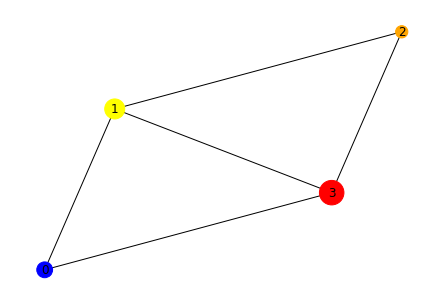

In [1]:
import networkx as nx
H = nx.DiGraph()

#adding nodes
H.add_nodes_from([
  (0, {"color": "blue", "size": 250}),

  (1, {"color": "yellow", "size": 400}),

  (2, {"color": "orange", "size": 150}),

  (3, {"color": "red", "size": 600})


])

#adding edges
H.add_edges_from([
  (0, 1),

  (1, 2),

  (1, 0),

  (1, 3),

  (2, 3),

  (3,0)


])

node_colors = nx.get_node_attributes(H, "color").values()
colors = list(node_colors)
node_sizes = nx.get_node_attributes(H, "size").values()
sizes = list(node_sizes)

# #Plotting Graph
# nx.draw(H, with_labels=True, node_color=colors, node_size=sizes)

#converting to undirected graph
G = H.to_undirected()
nx.draw(G, with_labels=True, node_color=colors, node_size=sizes)

In [2]:
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures


In [3]:
dataset = Planetoid(root = 'data/Planetoid' ,name= 'cora' , transform=NormalizeFeatures())
print(f'Dataset: {dataset}:')
print("---------------------------")
print(f'Number of features Dataset : {len(dataset)}')
print(f'Number of features : {dataset.num_features}')
print(f'Number of classes : {dataset.num_classes}')

data = dataset[0]
print(data)

Dataset: cora():
---------------------------
Number of features Dataset : 1
Number of features : 1433
Number of classes : 7
Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])


In [4]:
# create GNN using classes 
from torch_geometric.nn import GCNConv
import torch.nn.functional as F
import torch.nn as nn
import torch

class GCN(nn.Module):
    def __init__(self, hidden_channels):
        super(GCN , self).__init__()
        torch.manual_seed(1) # the printed random number will be different each time
        self.conv1 = GCNConv(dataset.num_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, dataset.num_classes)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training) # self.training --> True 
        x = self.conv2(x, edge_index)
        return x

model = GCN(hidden_channels=16)
print(model)

GCN(
  (conv1): GCNConv(1433, 16)
  (conv2): GCNConv(16, 7)
)


In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

def visualize(h, color):
    z = TSNE(n_components=2 , random_state= 0).fit_transform(h.detach().cpu().numpy())

    plt.figure(figsize=(10,10))
    plt.xticks([])
    plt.yticks([])

    plt.scatter(z[:, 0], z[:, 1], s=70, c=color, cmap="Set2")
    plt.show()

C:\Users\Zakaria Ahmed\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\Zakaria Ahmed\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


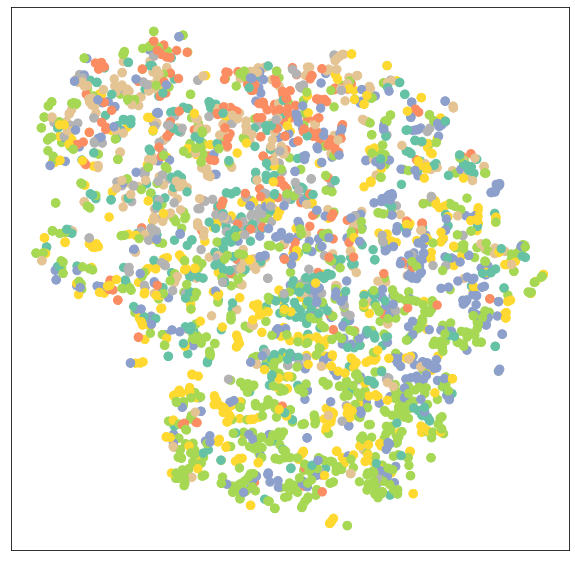

In [6]:
model.eval()

out = model(data.x, data.edge_index)
visualize(out, color=data.y)

In [7]:
model = GCN(hidden_channels=16)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()

def train():
      model.train()
      optimizer.zero_grad()
      out = model(data.x, data.edge_index)
      loss = criterion(out[data.train_mask], data.y[data.train_mask])
      loss.backward()
      optimizer.step()
      return loss

def test():
      model.eval()
      out = model(data.x, data.edge_index)
      pred = out.argmax(dim=1)
      test_correct = pred[data.test_mask] == data.y[data.test_mask]
      test_acc = int(test_correct.sum()) / int(data.test_mask.sum())
      return test_acc


for epoch in range(1, 101):
    loss = train()
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')


Epoch: 001, Loss: 1.9452
Epoch: 002, Loss: 1.9400
Epoch: 003, Loss: 1.9320
Epoch: 004, Loss: 1.9243
Epoch: 005, Loss: 1.9169
Epoch: 006, Loss: 1.9063
Epoch: 007, Loss: 1.9010
Epoch: 008, Loss: 1.8891
Epoch: 009, Loss: 1.8781
Epoch: 010, Loss: 1.8649
Epoch: 011, Loss: 1.8602
Epoch: 012, Loss: 1.8455
Epoch: 013, Loss: 1.8307
Epoch: 014, Loss: 1.8138
Epoch: 015, Loss: 1.8065
Epoch: 016, Loss: 1.7884
Epoch: 017, Loss: 1.7769
Epoch: 018, Loss: 1.7619
Epoch: 019, Loss: 1.7390
Epoch: 020, Loss: 1.7264
Epoch: 021, Loss: 1.7016
Epoch: 022, Loss: 1.6890
Epoch: 023, Loss: 1.6807
Epoch: 024, Loss: 1.6543
Epoch: 025, Loss: 1.6483
Epoch: 026, Loss: 1.6232
Epoch: 027, Loss: 1.6125
Epoch: 028, Loss: 1.6013
Epoch: 029, Loss: 1.5643
Epoch: 030, Loss: 1.5678
Epoch: 031, Loss: 1.5230
Epoch: 032, Loss: 1.4958
Epoch: 033, Loss: 1.4956
Epoch: 034, Loss: 1.4517
Epoch: 035, Loss: 1.4593
Epoch: 036, Loss: 1.4293
Epoch: 037, Loss: 1.4188
Epoch: 038, Loss: 1.3651
Epoch: 039, Loss: 1.3693
Epoch: 040, Loss: 1.3550


In [8]:
test_acc = test()
print(f'Test Accuracy: {test_acc:.4f}')

Test Accuracy: 0.8030


C:\Users\Zakaria Ahmed\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\Zakaria Ahmed\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


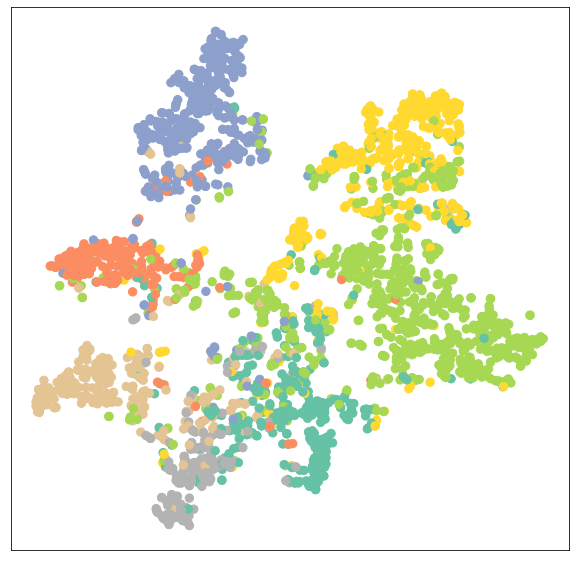

In [9]:
model.eval()
out = model(data.x, data.edge_index)
visualize(out, color=data.y)

In [10]:
from torch_geometric.nn import GATConv

class GAT(torch.nn.Module):
    def __init__(self, hidden_channels, heads):
        super().__init__()
        torch.manual_seed(1234567)
        self.conv1 = GATConv(dataset.num_features, hidden_channels,heads)
        self.conv2 = GATConv(heads*hidden_channels, dataset.num_classes,heads)

    def forward(self, x, edge_index):
        x = F.dropout(x, p=0.6, training=self.training)
        x = self.conv1(x, edge_index)
        x = F.elu(x)
        x = F.dropout(x, p=0.6, training=self.training)
        x = self.conv2(x, edge_index)
        return x

model = GAT(hidden_channels=8, heads=8)
print(model)

optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()

def train():
      model.train()
      optimizer.zero_grad()
      out = model(data.x, data.edge_index)
      loss = criterion(out[data.train_mask], data.y[data.train_mask])
      loss.backward()
      optimizer.step()
      return loss

def test(mask):
      model.eval()
      out = model(data.x, data.edge_index)
      pred = out.argmax(dim=1)
      correct = pred[mask] == data.y[mask]
      acc = int(correct.sum()) / int(mask.sum())
      return acc

val_acc_all = []
test_acc_all = []

for epoch in range(1, 101):
    loss = train()
    val_acc = test(data.val_mask)
    test_acc = test(data.test_mask)
    val_acc_all.append(val_acc)
    test_acc_all.append(test_acc)
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Val: {val_acc:.4f}, Test: {test_acc:.4f}')

GAT(
  (conv1): GATConv(1433, 8, heads=8)
  (conv2): GATConv(64, 7, heads=8)
)
Epoch: 001, Loss: 4.0245, Val: 0.1540, Test: 0.1660
Epoch: 002, Loss: 3.9907, Val: 0.1240, Test: 0.1310
Epoch: 003, Loss: 3.9534, Val: 0.0960, Test: 0.1100
Epoch: 004, Loss: 3.9121, Val: 0.0860, Test: 0.1020
Epoch: 005, Loss: 3.8659, Val: 0.0840, Test: 0.0920
Epoch: 006, Loss: 3.8015, Val: 0.0780, Test: 0.0890
Epoch: 007, Loss: 3.7434, Val: 0.0680, Test: 0.0800
Epoch: 008, Loss: 3.6690, Val: 0.0660, Test: 0.0760
Epoch: 009, Loss: 3.6004, Val: 0.0640, Test: 0.0740
Epoch: 010, Loss: 3.5158, Val: 0.0640, Test: 0.0720
Epoch: 011, Loss: 3.4187, Val: 0.0620, Test: 0.0710
Epoch: 012, Loss: 3.3205, Val: 0.0600, Test: 0.0690
Epoch: 013, Loss: 3.2355, Val: 0.0580, Test: 0.0670
Epoch: 014, Loss: 3.1221, Val: 0.0580, Test: 0.0670
Epoch: 015, Loss: 2.9988, Val: 0.0580, Test: 0.0670
Epoch: 016, Loss: 2.8735, Val: 0.0580, Test: 0.0660
Epoch: 017, Loss: 2.7678, Val: 0.0580, Test: 0.0660
Epoch: 018, Loss: 2.6441, Val: 0.0580

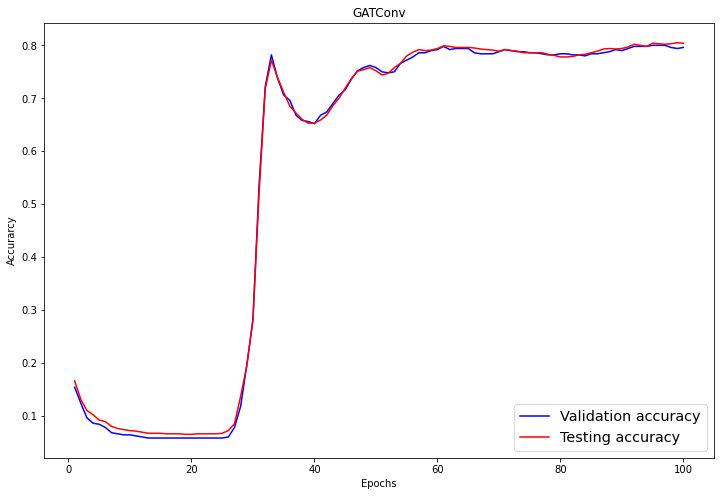

In [11]:
import numpy as np

plt.figure(figsize=(12,8))
plt.plot(np.arange(1, len(val_acc_all) + 1), val_acc_all, label='Validation accuracy', c='blue')
plt.plot(np.arange(1, len(test_acc_all) + 1), test_acc_all, label='Testing accuracy', c='red')
plt.xlabel('Epochs')
plt.ylabel('Accurarcy')
plt.title('GATConv')
plt.legend(loc='lower right', fontsize='x-large')
plt.savefig('gat_loss.png')
plt.show()

C:\Users\Zakaria Ahmed\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\Zakaria Ahmed\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


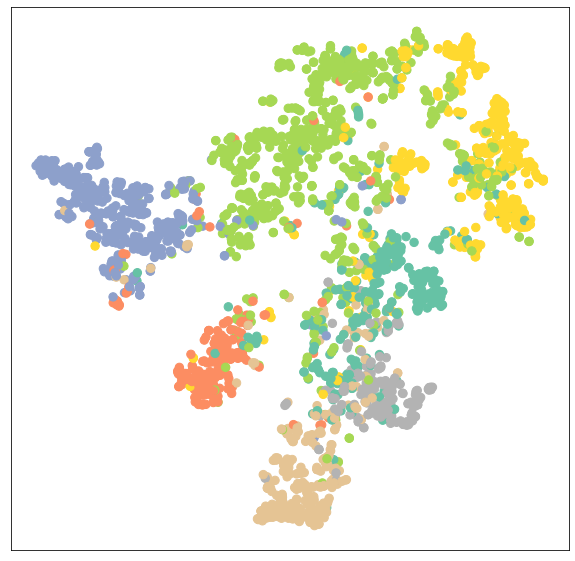

In [12]:
model.eval()

out = model(data.x, data.edge_index)
visualize(out, color=data.y)